# Ensemble Monte Carlo fitting of LG Beams

### Erik Flom, The University of Oklahoma

##### A Work in Progress: More functionality to be added soon!

## Generic Imports / Definitions

In [133]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy
import pylab
import pandas as pd
import pylab
import emcee
%matplotlib inline
pylab.rcParams['figure.figsize'] = (10,10)
plt.style.use('seaborn-white')
matplotlib.rcParams.update({'font.size': 20,
                           'font.fantasy':'Helvetica'})


[u'seaborn-darkgrid',
 u'seaborn-notebook',
 u'classic',
 u'seaborn-ticks',
 u'grayscale',
 u'bmh',
 u'seaborn-talk',
 u'dark_background',
 u'ggplot',
 u'fivethirtyeight',
 u'seaborn-colorblind',
 u'seaborn-deep',
 u'seaborn-whitegrid',
 u'seaborn-bright',
 u'seaborn-poster',
 u'seaborn-muted',
 u'seaborn-paper',
 u'seaborn-white',
 u'seaborn-pastel',
 u'seaborn-dark',
 u'seaborn-dark-palette']

## Import Data

### Data are put into a single 3-D array of index:

### [NumberOfDataPoints, Y_Resolution, X_Resolution]

In [2]:
NumberOfPoints=25

LocationOnDisk="C:/Users/EFlom/Documents/Data/1-0/July_14/"
data = np.zeros([NumberOfPoints,1024,1024]) 
data_err = np.zeros([NumberOfPoints,1024,1024]) 
## 1039x1392 is the pixel size of our CCD Camera

for i in range(NumberOfPoints):
    data_string = LocationOnDisk + str(2*i+1) + "_" + "%04d" % (1) + ".asc"
    data[i,:,:] = pd.read_table(data_string, skiprows=7, nrows=1024, usecols = range(188,1212))
    data_err[i,:,:] = np.sqrt(data[i,:,:])
  
X, Y = np.meshgrid(np.arange(1,1025,1), np.arange(1,1025,1))


print("Done!")

Done!


## Generate 2D histograms of the Data (eye test)

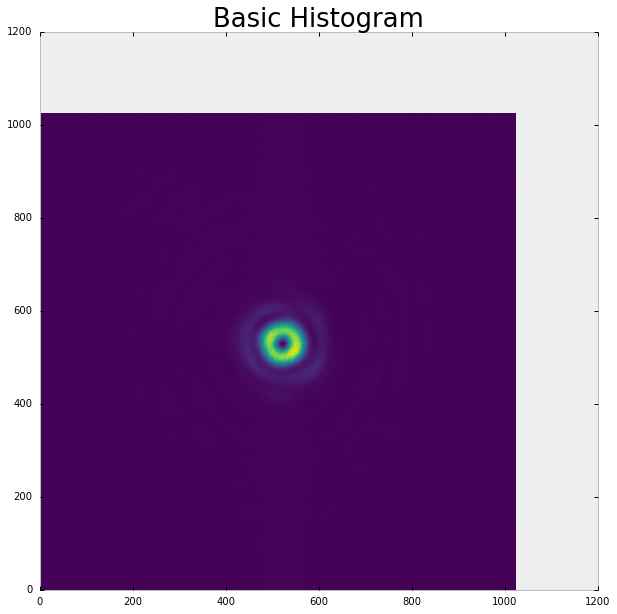

In [75]:
pylab.rcParams['figure.figsize'] = (10,10)
plt.pcolormesh(data[3,:,:], cmap='viridis')

plt.title('Basic Histogram')
plt.show()

### Plot Cross-Section of Data (eye test)

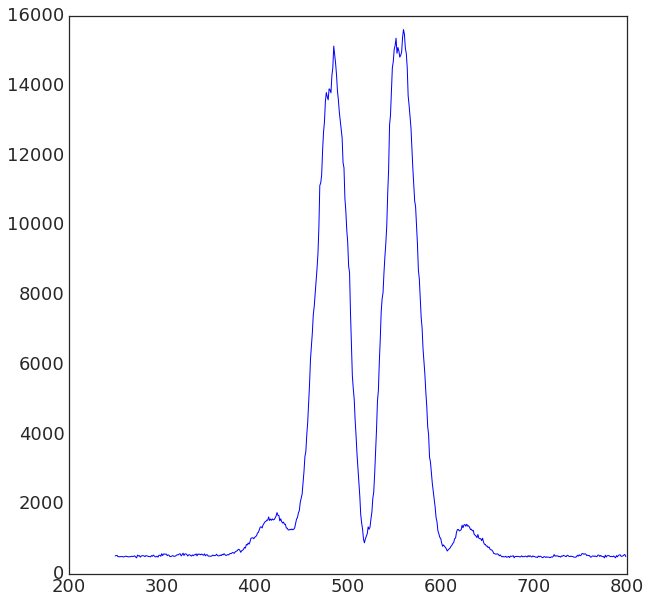

In [84]:
#This plots a cross-section at a specified y pixel row across the range of [xmin, xmax]

xmin = 250
xmax = 800
y_val = 500

cross_section = data[4, y_val, xmin:xmax]
x = np.arange(xmin, xmax, 1)
plt.plot(x, cross_section)


In [87]:
binfactor=4

#  Monte Carlo Routine

## Definition of Various Beam Modes and Initial Value Guesses

In [88]:
def Mode_1_0(params, binfactor = binfactor):
       
    X, Y = np.meshgrid(np.arange(1,1025,binfactor), np.arange(1,1025,binfactor))    
    A=((params[0]**2)*(2.*((X - params[4])**2. + (Y - params[3])**2.)/(params[1])**2.))**1
    B=1.
    C=np.exp((-2.)*(((X - params[4])**2. + (Y - params[3])**2.)/(params[1])**2.))
    
    return (A*B*C) + params[2]  
    
def Mode_2_1(params, binfactor = binfactor):
    X, Y = np.meshgrid(np.arange(1,1025,binfactor), np.arange(1,1025,binfactor))
    A=(params[0]*(2.*((X - params[4])**2. + (Y - params[3])**2.)/(params[1])**2.))**2
    B=((3. - ((2.*((X - params[4])**2. + (Y - params[3])**2.))/(params[1])**2.))**2.)
    C=np.exp((-2.)*(((X - params[4])**2. + (Y - params[3])**2.)/(params[1])**2.))
    
    return (A*B*C) + params[2]  
    
def Mode_10_1(params):
    
    A=(params[0]*(2.*((X - params[4])**2. + (Y - params[3])**2.)/(params[1])**2.))**10
    B=((3. - ((2.*((X - params[4])**2. + (Y - params[3])**2.))/(params[1])**2.))**2.)
    C=np.exp((-2.)*(((X - params[4])**2. + (Y - params[3])**2.)/(params[1])**2.))
    
    return (A*B*C) + params[2]  
    
def Mode_5_0(params):
    
    A=(params[0]*(2.*((X - params[4])**2. + (Y - params[3])**2.)/(params[1])**2.))**5
    B=((3. - ((2.*((X - params[4])**2. + (Y - params[3])**2.))/(params[1])**2.))**2.)
    C=np.exp((-2.)*(((X - params[4])**2. + (Y - params[3])**2.)/(params[1])**2.))
    
    return (A*B*C) + params[2]  

def Mode_5_1(params):
    
    A=(params[0]*(2.*((X - params[4])**2. + (Y - params[3])**2.)/(params[1])**2.))**5
    B=((3. - ((2.*((X - params[4])**2. + (Y - params[3])**2.))/(params[1])**2.))**2.)
    C=np.exp((-2.)*(((X - params[4])**2. + (Y - params[3])**2.)/(params[1])**2.))
    
    return (A*B*C) + params[2]  


## Instantiation of Walkers, addition of small random initial perturbation around guesses

## Definition of Prior, Likelihood, and Posterior 

In [89]:
def log_prior1(param):
    scale_min = 100.0
    scale_max = 4000.0
    width_min = 20.0
    width_max = 250.0
    baseline_min = 100.0
    baseline_max = 1200.0
    x0_min = 450.0
    x0_max = 650.0
    y0_min = 450.0
    y0_max = 650.0
        
    if ((scale_min <= param[0] <= scale_max) and
    (width_min <= param[1] <= width_max) and
    (baseline_min <= param[2] <= baseline_max)and 
    (x0_min <= param[3] <= x0_max)and 
    (y0_min <= param[4] <= y0_max)): 

        return 0.0
    
    else:
        return -np.inf
 


def log_likelihood(param, z, data_err):
    model = Mode_1_0(param[:5])# + Mode_1_0(param[5:])
    likelihood = (-0.5)*(np.sum(np.sum(((model - z)/data_err)**2))) - np.log(np.size(z))
    return likelihood

def log_posterior(param, z, data_err):
    return (log_prior1(param[:5]) + log_likelihood(param, z, data_err))/(np.size(z) - 5)

## Definition of Binning Function (note: binfactor must be power of 2)

In [90]:

X, Y = np.meshgrid(np.arange(1,1024 +1 ,binfactor), np.arange(1,1024 + 1,binfactor))
params = [300,25,600,550,550]

nwalkers = 50
z = Mode_1_0(params[:5])


def rebin(arr, new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

## Definition of Main() Function -- This is what actually implements the MCMC. It is called in the next cell.

In [91]:
def Main(data_to_fit, errors_to_fit, guesses, numsims=500, burnin=250, nwalkers=100):

    ndim = 5
    
    nwalkers = 50
    
    scale_i1 = guesses[0]+100.0*np.random.randn(nwalkers)
    width_i1 = guesses[1]+5.0*np.random.randn(nwalkers)
    baseline_i1 = guesses[2]+30.0*np.random.randn(nwalkers)
    x0_i1 = guesses[3]+10.0*np.random.randn(nwalkers)
    y0_i1 = guesses[4]+10.0*np.random.randn(nwalkers)
    

    pos = [scale_i1]+[width_i1]+[baseline_i1]+[x0_i1]+[y0_i1]
    posNew=(np.array(pos)).T

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[data_to_fit, errors_to_fit])
    %time sampler.run_mcmc(posNew, numsims) # %time is used to time this line of the function. It will print the CPU time in the output
    
    chain=sampler.chain
    lnprob=sampler.lnprobability
    acceptance=sampler.acceptance_fraction
    
    
    percent_regions=[1.0-0.9973,1.0-0.9545,1.0-0.6827,0.5,0.6827,0.9545,0.9973]

    confidence_regions_params=np.zeros([7,ndim])

    acceptances = [np.percentile(acceptance, 5), np.percentile(acceptance, 50), np.percentile(acceptance, 95)]
    scale = [np.percentile(chain[:,burnin:numsims,0], 5), np.percentile(chain[:,burnin:numsims,0], 50), np.percentile(chain[:,burnin:numsims,0], 95)]
    width =  [np.percentile(chain[:,burnin:numsims,1], 5), np.percentile(chain[:,burnin:numsims,1], 50), np.percentile(chain[:,burnin:numsims,1], 95)]
    background =  [np.percentile(chain[:,burnin:numsims,2], 5), np.percentile(chain[:,burnin:numsims,2], 50), np.percentile(chain[:,burnin:numsims,2], 95)]
    x0 =  [np.percentile(chain[:,burnin:numsims,3], 5), np.percentile(chain[:,burnin:numsims,3], 50), np.percentile(chain[:,burnin:numsims,3], 95)]
    y0 =  [np.percentile(chain[:,burnin:numsims,4], 5), np.percentile(chain[:,burnin:numsims,4], 50), np.percentile(chain[:,burnin:numsims,4], 95)]
    logPDF = [np.percentile(lnprob[:, burnin:numsims], 5), np.percentile(lnprob[:, burnin:numsims], 50), np.percentile(lnprob[:, burnin:numsims], 95)]
    
    
    return acceptances, scale, width, background, x0, y0, logPDF, chain, lnprob, acceptance
    

## Calling the Main() within a For loop to analyze entire data series. Input initial guesses here.

In [92]:
ndim = 5
numsims = 300
nwalkers=50
burnin=200
X, Y = np.meshgrid(np.arange(1,1024 +1 ,binfactor), np.arange(1,1024 + 1,binfactor))

guesses = [300,25,600,550,550] #guesses ONLY for first run. Everything else done recursively.


scale_i1 = params[0]+75.0*np.random.randn(nwalkers)
width_i1 = params[1]+5.0*np.random.randn(nwalkers)
baseline_i1 = params[2]+50.0*np.random.randn(nwalkers)
x0_i1 = params[3]+20.0*np.random.randn(nwalkers)
y0_i1 = params[4]+20.0*np.random.randn(nwalkers)


acceptances = np.zeros((NumberOfPoints,3))
scales = np.zeros((NumberOfPoints,3))
widths = np.zeros((NumberOfPoints,3))
backgrounds = np.zeros((NumberOfPoints,3))
x0s = np.zeros((NumberOfPoints,3))
y0s = np.zeros((NumberOfPoints,3))
logPDFs = np.zeros((NumberOfPoints,3))
chain = np.zeros((NumberOfPoints, nwalkers, numsims, ndim))
lnprob = np.zeros((NumberOfPoints, nwalkers, numsims))
acceptance = np.zeros((NumberOfPoints, nwalkers))


for i in range(NumberOfPoints):
    
    data_new = rebin(data[i,:,:], (1024/binfactor,1024/binfactor))
    err_new = rebin(data_err[i,:,:], (1024/binfactor,1024/binfactor))
    
    acceptances[i,:], scales[i,:], widths[i,:], backgrounds[i,:], x0s[i,:], y0s[i,:], logPDFs[i,:], chain[i,:,:,:], lnprob[i,:,:], acceptance[i,:] = Main(data_new, err_new, guesses, numsims, burnin, nwalkers)
    
    guesses[1] = guesses[1] + 6
    

Wall time: 1min 15s
Wall time: 1min 3s
Wall time: 1min 19s
Wall time: 1min 27s
Wall time: 1min 26s
Wall time: 1min 17s
Wall time: 1min 33s
Wall time: 1min 8s
Wall time: 1min 1s
Wall time: 1min 7s
Wall time: 1min 13s
Wall time: 1min 1s
Wall time: 1min 22s
Wall time: 1min 16s
Wall time: 1min 8s
Wall time: 1min 35s
Wall time: 48.8 s
Wall time: 50.8 s
Wall time: 1min 16s
Wall time: 56.4 s
Wall time: 1min 14s
Wall time: 1min 32s
Wall time: 1min 14s
Wall time: 1min 4s
Wall time: 57.9 s


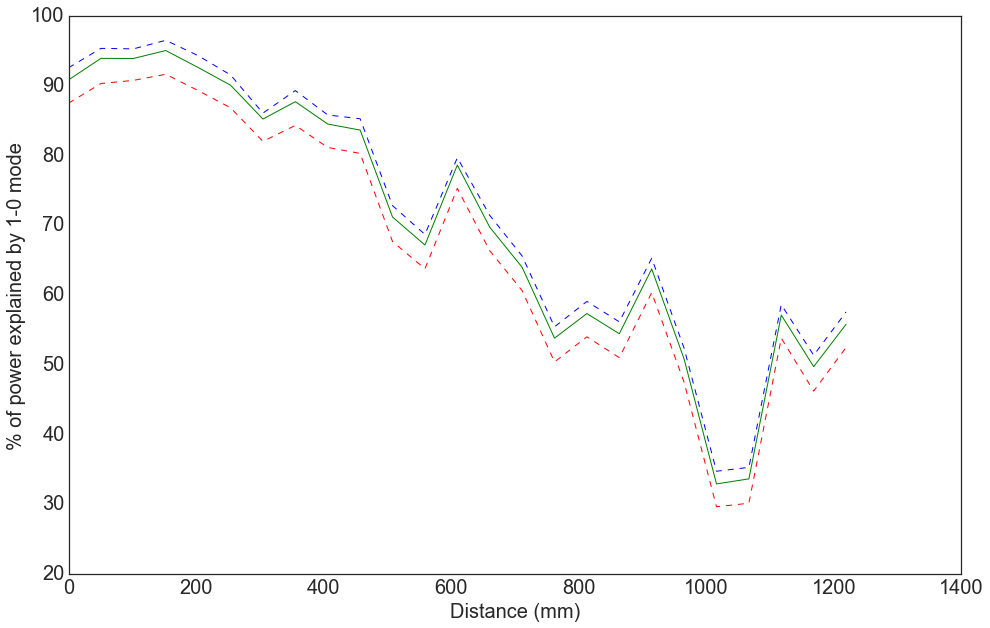

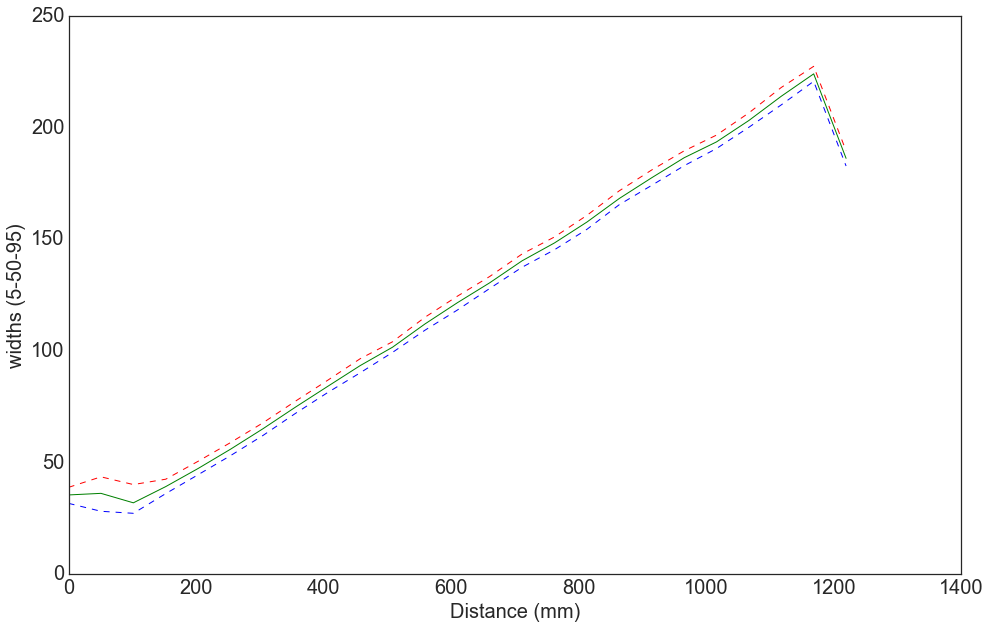

In [157]:
pylab.rcParams['figure.figsize'] = (16,10)
plt.plot(np.arange(25)*50.8,logPDFs[:,0]+105+1*np.arange(25), ls="--")
plt.plot(np.arange(25)*50.8,logPDFs[:,1]+100+1*np.arange(25), lw = 1)
plt.plot(np.arange(25)*50.8,logPDFs[:,2]+95+1*np.arange(25), ls='--')
plt.xlabel('Distance (mm)')
plt.ylabel('% of power explained by 1-0 mode')
plt.show()

pylab.rcParams['figure.figsize'] = (16,10)
plt.plot(np.arange(25)*50.8,widths[:,0], ls="--")
plt.plot(np.arange(25)*50.8,widths[:,1], lw = 1)
plt.plot(np.arange(25)*50.8,widths[:,2], ls='--')
plt.xlabel('Distance (mm)')
plt.ylabel('widths (5-50-95)')
plt.show()

In [ ]:
widths

## Plot Histograms of Parameters

In [ ]:
z = Mode_1_0(params)
            
pylab.rcParams['figure.figsize'] = (10,10)            
plt.pcolormesh(data_new, cmap='viridis')

In [ ]:
print np.shape(acceptance)
plt.plot(acceptance[:])
plt.xlabel('Walker no.')
plt.ylabel('Acceptance Fraction')

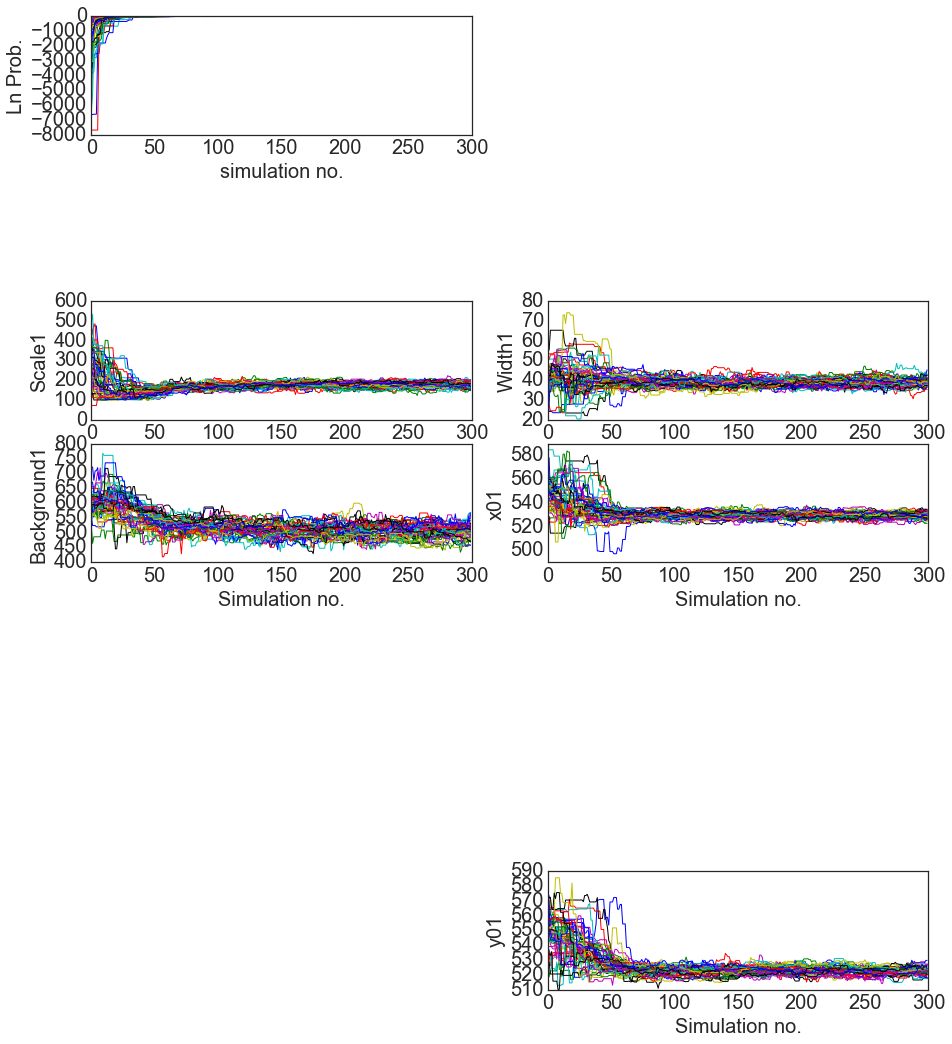

In [165]:
### Analyze walker movement for a specific trial number

trial_to_examine = 6


index = np.arange(numsims)
from matplotlib import pyplot
trial_to_examine = 3
burnin=0
pylab.rcParams['figure.figsize'] = (15,20)
for i in range(nwalkers):
    pyplot.subplot(8,2,1)
    plt.plot(index[burnin:], lnprob[trial_to_examine,i, burnin:numsims])
    plt.xlabel('simulation no.')
    plt.ylabel('Ln Prob.')
    
    pyplot.subplot(8,2,5)
    plt.plot(index[burnin:], chain[trial_to_examine,i,burnin:numsims,0])
    plt.xlabel('Simulation no.')
    plt.ylabel('Scale1')
    
    pyplot.subplot(8,2,6)
    plt.plot(index[burnin:], chain[trial_to_examine,i,burnin:numsims,1])
    plt.xlabel('Simulation no.')
    plt.ylabel('Width1')
    
    pyplot.subplot(8,2,7)
    plt.plot(index[burnin:], chain[trial_to_examine,i,burnin:numsims,2])
    plt.xlabel('Simulation no.')
    plt.ylabel('Background1')
    
    pyplot.subplot(8,2,8)
    plt.plot(index[burnin:], chain[trial_to_examine,i,burnin:numsims,3])
    plt.xlabel('Simulation no.')
    plt.ylabel('x01')
    
    pyplot.subplot(8,2,14)
    plt.plot(index[burnin:], chain[trial_to_examine,i,burnin:numsims,4])
    plt.xlabel('Simulation no.')
    plt.ylabel('y01')
    

    
plt.show()
    

In [162]:
pylab.rcParams['figure.figsize'] = (20,0)
for i in range(nwalkers):

    plt.plot(index[burnin:], chain[trial_to_examine,i,burnin:numsims,0])
    plt.xlabel('Simulation no.')
    plt.ylabel('Scale1')
plt.show()


TypeError: 'int' object has no attribute '__getitem__'

(25L, 50L, 300L, 5L)


ValueError: cannot reshape array of size 0 into shape (2500,300)

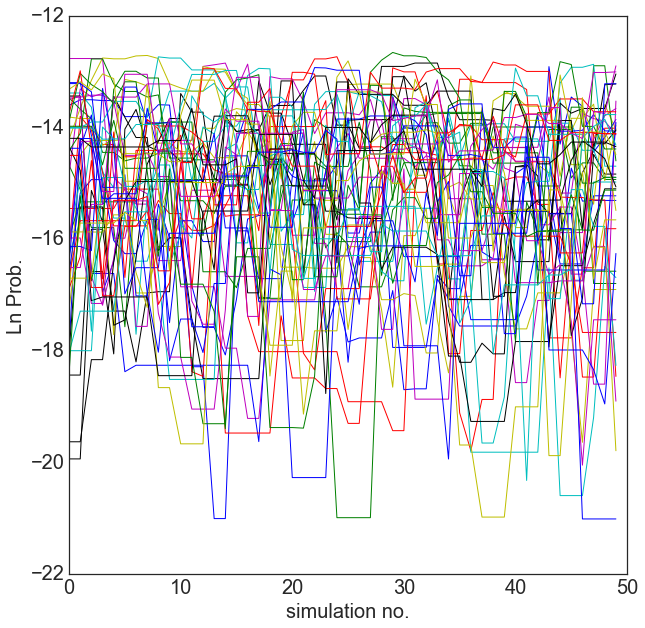

In [140]:
def MakeHistogram(trial_no, samples, burnin, index, numbins):
    samples = samples[trial_no,:,:,:]
    numout=len(samples)
    comp=samples[0:numout,burnin:,index]
    comp_histogram=np.array(np.histogram(comp,bins=numbins,range=[comp.min(),comp.max()]))
    comp_histogram_y=comp_histogram[0]
    temp=comp_histogram[1]
    binsize=temp[1]-temp[0]
    comp_histogram_x=comp.min()+0.5*binsize+binsize*np.arange(numbins)
    return comp_histogram_x,comp_histogram_y

print chain.shape
burnin=250
ndim=chain.shape[2]



for i in range(nwalkers):
    plt.plot(np.arange(numsims-burnin), lnprob[5,i, burnin:numsims])
    plt.xlabel('simulation no.')
    plt.ylabel('Ln Prob.')

lnprob2=lnprob[:,burnin:].reshape((-1))
temp=chain[:,burnin:,0:ndim]
sample=temp.reshape(((numsims-burnin)*nwalkers,ndim))

print lnprob2.shape
print sample.shape
print np.mean(lnprob[:, burnin:numsims])

## Make Histogram of Scaling Factor

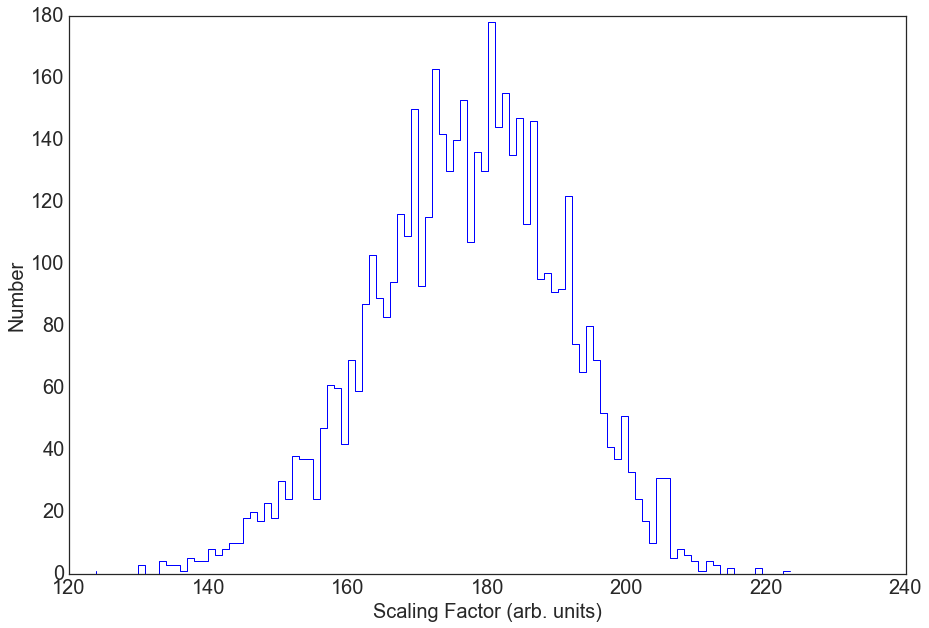

In [146]:
index=0
numbins = 100
burnin=200
pylab.rcParams['figure.figsize'] = (15,10)
comp_hist_0_x,comp_hist_0_y=MakeHistogram(trial_to_examine,chain,burnin,index,numbins)
plt.xlabel('Scaling Factor (arb. units)')
plt.ylabel('Number')
plt.plot(comp_hist_0_x,comp_hist_0_y,drawstyle='steps', fillstyle='bottom')

## Make Histogram of Width

In [ ]:
index=1
comp_hist_0_x,comp_hist_0_y=MakeHistogram(trial_to_examine,chain,burnin,index,numbins)
plt.xlabel('Width (CCD Pixels)')
plt.ylabel('Number')
plt.plot(comp_hist_0_x,comp_hist_0_y,drawstyle='steps')

## Make Histogram of Baseline

In [ ]:
index=2
comp_hist_0_x,comp_hist_0_y=MakeHistogram(trial_to_examine,chain,burnin,index,numbins)
plt.xlabel('Baseline (arb. units)')
plt.ylabel('Number')
plt.plot(comp_hist_0_x,comp_hist_0_y,drawstyle='steps')

## Make Histogram of x0

In [ ]:
index=3
comp_hist_0_x,comp_hist_0_y=MakeHistogram(trial_to_examine,chain,burnin,index,numbins)
plt.xlabel('x0 (CCD index)')
plt.ylabel('Number')
plt.plot(comp_hist_0_x,comp_hist_0_y,drawstyle='steps')

## Make Histogram of y0

In [ ]:
index=4
comp_hist_0_x,comp_hist_0_y=MakeHistogram(trial_to_examine,chain,burnin,index,numbins)
plt.xlabel('y0 (CCD index)')
plt.ylabel('Number')
plt.plot(comp_hist_0_x,comp_hist_0_y,drawstyle='steps')

In [ ]:
percent_regions=[1.0-0.9973,1.0-0.9545,1.0-0.6827,0.5,0.6827,0.9545,0.9973]

confidence_regions_params=np.zeros([7,ndim])

numsamples=len(sample)

for i in np.arange(ndim):
    temp=sample[:,i]
    x2=np.sort(temp)
    f2=np.array(range(numsamples))/float(numsamples)
    confidence_regions_params[0:7,i]=np.interp(percent_regions,f2,x2)

print 'The median value of Scale is ',confidence_regions_params[4,0], ' 95% interval:', [confidence_regions_params[1,0],confidence_regions_params[6,0]]
print 'The median value of Width is ',confidence_regions_params[4,1], '   95% interval:', [confidence_regions_params[1,1],confidence_regions_params[6,1]]
print 'The median value of Baseline is ',confidence_regions_params[4,2], '  95% interval:', [confidence_regions_params[1,2],confidence_regions_params[6,2]]
print 'The median value x0 is ',confidence_regions_params[4,3], '  95% interval:', [confidence_regions_params[1,3],confidence_regions_params[6,3]]
print 'The median value of y0 is ',confidence_regions_params[4,4], '  95% interval:', [confidence_regions_params[1,4],confidence_regions_params[6,4]]


## Plot Redisuals

(5L,)


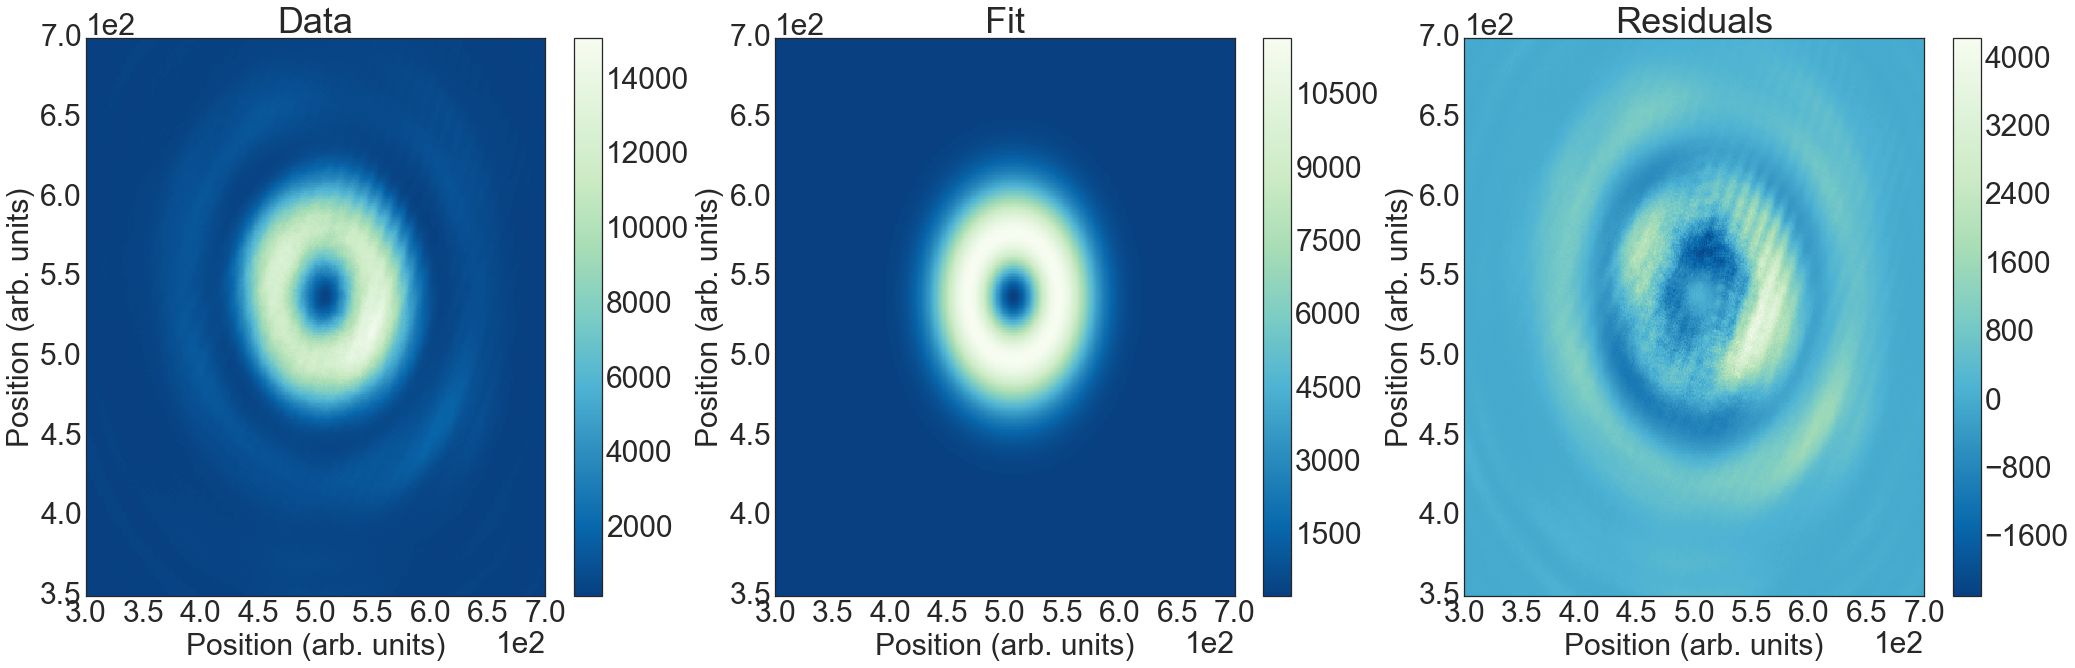

In [131]:
trial_to_examine = 5
burnin=250
pylab.rcParams['figure.figsize'] = (35,10)
fitted_params=chain[trial_to_examine,:,burnin:,:]
fitted_params = np.mean(fitted_params, axis=0)
fitted_params = np.mean(fitted_params, axis=0)
print np.shape(fitted_params)
fitted_curve=Mode_1_0([fitted_params[0],fitted_params[1],fitted_params[2],fitted_params[3],fitted_params[4]],1) #+ Mode_1_0(fitted_params[5:], 1)



data_new = data[trial_to_examine,:,:]
pyplot.subplot(1,3,1)
plt.title('Data')
plt.xlabel('Position (arb. units)')
plt.ylabel('Position (arb. units)')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.pcolormesh(data[trial_to_examine,:,:], cmap='GnBu_r')

plt.xlim(300,700)
plt.ylim(350,700)
plt.colorbar()
pyplot.subplot(1,3,2)
plt.title('Fit')
plt.xlabel('Position (arb. units)')
plt.ylabel('Position (arb. units)')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.pcolormesh(fitted_curve, cmap='GnBu_r')
plt.colorbar()
plt.xlim(300,700)
plt.ylim(350,700)
pyplot.subplot(1,3,3)
plt.title('Residuals')
plt.xlabel('Position (arb. units)')
plt.ylabel('Position (arb. units)')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.pcolormesh(data[trial_to_examine,:,:] - fitted_curve, cmap='GnBu_r')
plt.colorbar()
plt.xlim(300,700)
plt.ylim(350,700)
plt.show()

In [ ]:
import scipy.stats
print np.corrcoef(data[trial_to_examine], fitted_curve)
print np.mean(np.corrcoef(data[trial_to_examine], fitted_curve))